In [ ]:
  import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import datetime

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1ji0Stj7xl4HWKYptkDCibEE2XHYyF6Wl'
downloaded = drive.CreateFile({'id': id})

downloaded.GetContentFile('train_transaction.csv')

df = pd.read_csv('train_transaction.csv')

id='1h5nClzzoNaX4t5rpvKbs1djxAM_VRI81'
downloaded = drive.CreateFile({'id': id})

downloaded.GetContentFile('train_identity.csv')

df_id = pd.read_csv('train_identity.csv')

id='16KBWbCNC_AEpn_lqtmtDfDfsoLsX6wDK'
downloaded = drive.CreateFile({'id': id})

downloaded.GetContentFile('test_transaction.csv')

df_test = pd.read_csv('test_transaction.csv')

id='1Z0MEgka6hlAm-qd5Gh-fk9zLiMfOaZ0c'
downloaded = drive.CreateFile({'id': id})

downloaded.GetContentFile('test_identity.csv')

df_id_test = pd.read_csv('test_identity.csv')

In [ ]:
df = df.join(df_id.set_index('TransactionID'), on='TransactionID', how='outer')
df_test = df_test.join(df_id_test.set_index('TransactionID'), on='TransactionID', how='outer')

In [ ]:
split = int(df.shape[0] * 0.8)# 80-20 train validation split
train = df.iloc[:split,:]
validation = df.iloc[split:,:]
#train set is the uper rows and validation the lower ones as the dataframe is sorted by time
#this prevents future information to predict the past

In [ ]:
#replaces the names on the columns from the test set by the ones in the train set
#test set has the same columns except isFraud this is just because of spelling errors
import numpy as np
columns_true = list(train.columns)
columns_true.pop(1)
columns_dict = {}
columns_false = list(df_test.columns)
for i, v in enumerate(columns_true):
  columns_dict[columns_false[i]] = v 
df_test.rename(columns=columns_dict, inplace=True)

In [ ]:
import gc
df = None
gc.collect()

222

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
#mean encoding for every object column
#makes NaN a category by making it a string
for column in train:
  if train[column].dtype == 'object':
    train[column] = train[column].fillna('NaN')
    validation[column] = validation[column].fillna('NaN')
    df_test[column] = df_test[column].fillna('NaN')
    mean_dict = dict(train.groupby(column)['isFraud'].mean())
    train.replace({column : mean_dict},inplace=True)
    validation.replace({column : mean_dict},inplace=True) #instead of mean encoding the validation set with its own data it encodes it with trains data
    df_test.replace({column : mean_dict},inplace=True) #same here

In [ ]:
#fill NaN values in numeric columns with the average of that column
column_means = train.mean()
train = train.fillna(column_means)
validation = validation.fillna(column_means)
column_means.drop(column_means.index[1]) #remove 'isFraud' mean
df_test = df_test.fillna(column_means)

In [ ]:
#split target from features and remove unique ids
train_target = train['isFraud'].copy()
validation_target = validation['isFraud'].copy()
train = train.drop(['TransactionID', 'isFraud'], axis=1)
validation = validation.drop(['TransactionID', 'isFraud'], axis=1)
df_test_t_id = df_test['TransactionID'].copy()
df_test = df_test.drop(['TransactionID'], axis=1)

In [ ]:
gc.collect()

100

In [ ]:
#trains model, seed is used to guarantee reproducibility
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
model = LogisticRegression(random_state=54836, max_iter=2000)
penalty = ['none', 'l2']
solver = ['lbfgs', 'liblinear']
hp = dict(penalty=penalty, solver=solver)
search = RandomizedSearchCV(model, hp, n_iter=200, scoring='roc_auc', n_jobs=1, cv=2, random_state=54836, verbose=10)
search.fit(train, train_target)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=200. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2; 1/4] START penalty=none, solver=lbfgs..................................
[CV 1/2; 1/4] END ...penalty=none, solver=lbfgs;, score=0.665 total time=  33.3s
[CV 2/2; 1/4] START penalty=none, solver=lbfgs..................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/2; 1/4] END ...penalty=none, solver=lbfgs;, score=0.700 total time= 6.3min
[CV 1/2; 2/4] START penalty=none, solver=liblinear..............................
[CV 1/2; 2/4] END .penalty=none, solver=liblinear;, score=nan total time=   1.7s
[CV 2/2; 2/4] START penalty=none, solver=liblinear..............................
[CV 2/2; 2/4] END .penalty=none, solver=liblinear;, score=nan total time=   0.5s
[CV 1/2; 3/4] START penalty=l2, solver=lbfgs....................................
[CV 1/2; 3/4] END .....penalty=l2, solver=lbfgs;, score=0.665 total time=  41.8s
[CV 2/2; 3/4] START penalty=l2, solver=lbfgs....................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/2; 3/4] END .....penalty=l2, solver=lbfgs;, score=0.722 total time= 6.4min
[CV 1/2; 4/4] START penalty=l2, solver=liblinear................................
[CV 1/2; 4/4] END .penalty=l2, solver=liblinear;, score=0.504 total time=  22.7s
[CV 2/2; 4/4] START penalty=l2, solver=liblinear................................
[CV 2/2; 4/4] END .penalty=l2, solver=liblinear;, score=0.713 total time= 3.3min


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 8.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is not s

RandomizedSearchCV(cv=2,
                   estimator=LogisticRegression(max_iter=2000,
                                                random_state=54836),
                   n_iter=200, n_jobs=1,
                   param_distributions={'penalty': ['none', 'l2'],
                                        'solver': ['lbfgs', 'liblinear']},
                   random_state=54836, scoring='roc_auc', verbose=10)

In [ ]:
#AUC ROC score for prediction made with the train set
from sklearn.metrics import roc_auc_score
roc_auc_score(train_target, search.predict_proba(train)[:, 1])

0.687277687203347

In [ ]:
#this is done because there are object values in the validation set that dont apear in the train set so they arent encoded
#this values are encoded with the mean value of the column in the train set
columns_new_values = []
for column in train:
  validation[column] = validation[column].map(lambda x: x if np.isreal(x) else train[column].mean())
  df_test[column] = df_test[column].map(lambda x: x if np.isreal(x) else train[column].mean())

In [ ]:
#AUC ROC score for prediction made with the validation set
roc_auc_score(validation_target, search.predict_proba(validation)[:, 1])

0.6972313723298399

In [ ]:
train = None
validation = None
gc.collect()

148

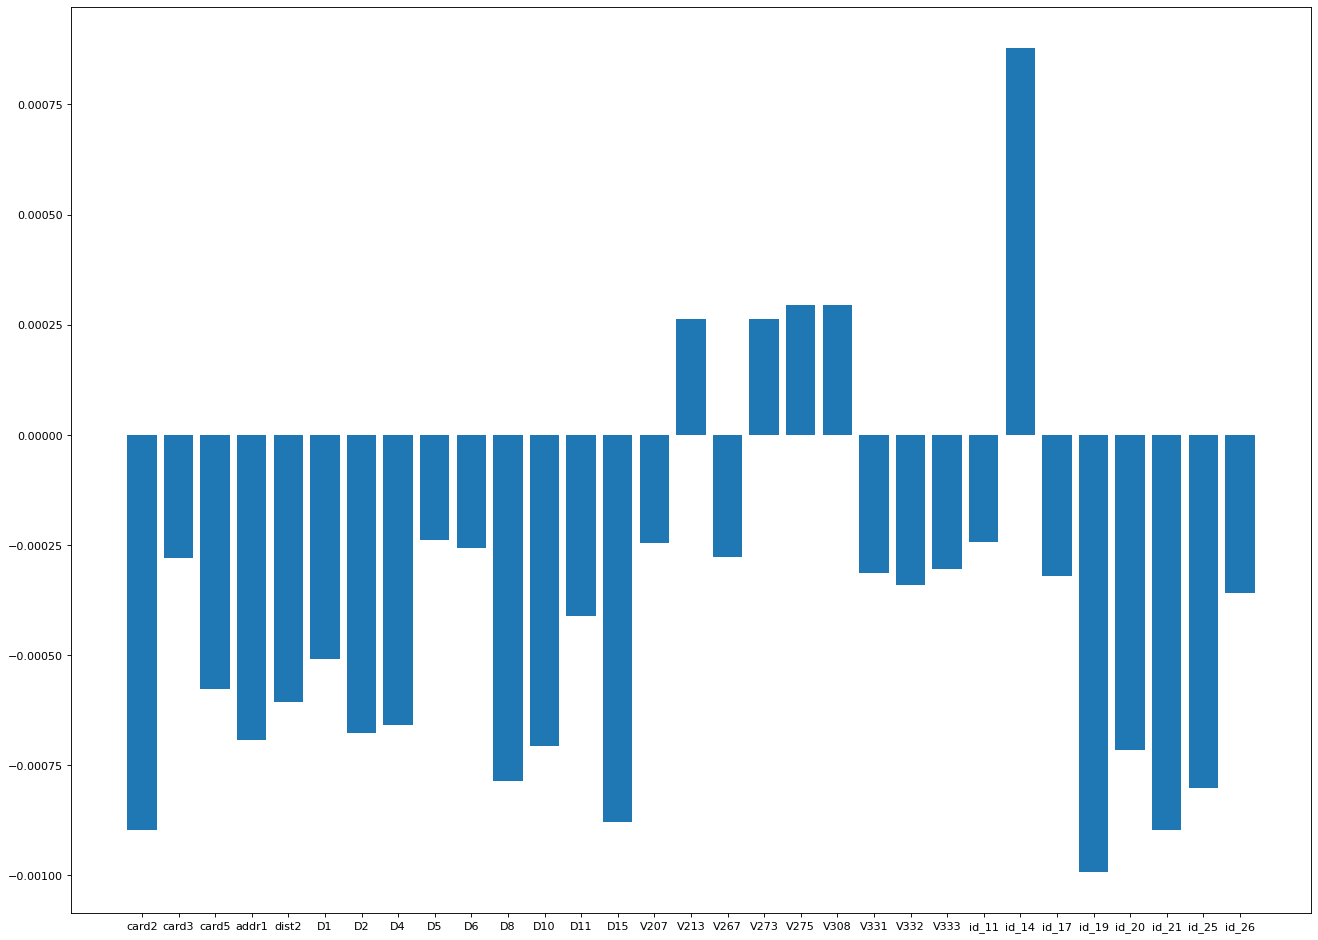

In [ ]:
#visualization of the model's weights
#this gives an idea of witch features are more important
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
weights = search.best_estimator_.coef_[0]
abs_mean = np.abs(weights).mean()
columns = df_test.columns
wanted_weights = {}
for i, v in enumerate(weights): #this loop filters out small values to make the graph more understandable
  if abs(v) > abs_mean * 4:
    wanted_weights[columns[i]] = v

figure(figsize=(20, 15), dpi=80)
y_pos = np.arange(len(wanted_weights))
plt.bar(y_pos, wanted_weights.values())
plt.xticks(y_pos, wanted_weights.keys())
plt.show()

In [ ]:
gc.collect()

5923

In [ ]:
#run this to download the tests predictions csv
from google.colab import files
predictions = search.predict_proba(df_test)
predictions_df = pd.DataFrame(data=predictions[:, 1], columns=['isFraud'])
save = pd.concat([pd.Series(df_test_t_id.tolist()), predictions_df], axis=1)
save.columns = ['TransactionID', 'isFraud']
save.to_csv('prediction.csv', index = False)
files.download("prediction.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

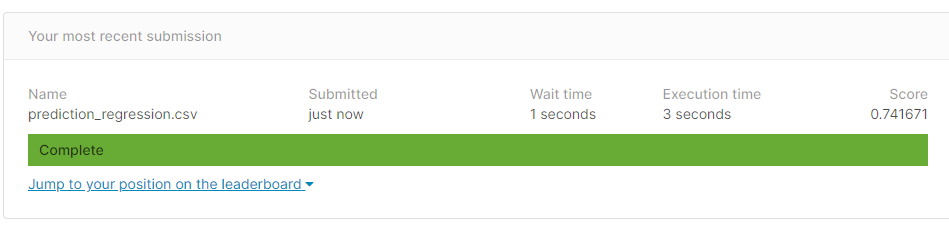